### UNet and ISBI2012

在该实现中您可以看到如下功能：
1. 读取 ISBI 2012 数据集
2. 更为灵活的网络结构定义和 UNet 的实现

In this template you can finish the following functions:
1. Read the ISBI 2012 data set
2. More flexible network structure definition and UNet implementation

In [1]:
# ;wget "https://github.com/tczhangzhi/Julia-Deeplearning/releases/download/v0.0.2/ISBI2012.zip"

In [2]:
# ;unzip ISBI2012.zip

In [3]:
using Base.Iterators: partition
using Flux
using Flux.Optimise: update!
using Flux: logitbinarycrossentropy
using Images
using MLDatasets
using Statistics
using Parameters: @with_kw
using Printf
using Random

In [4]:
using CUDAapi, CUDAdrv, CUDAnative
gpu_id = 3  ## set < 0 for no cuda, >= 0 for using a specific device (if available)

if has_cuda_gpu() && gpu_id >=0
    device!(gpu_id)
    device = Flux.gpu
    @info "Training on GPU-$(gpu_id)"
else
    device = Flux.cpu
    @info "Training on CPU"
end

┌ Info: Training on GPU-3
└ @ Main In[4]:7


In [5]:
using Parameters: @with_kw
@with_kw mutable struct Args
    lr::Float64 = 1e-4
end

Args

In [6]:
# Example script of how you can train this UNet and do inference
using Images, FileIO, JLD2, Flux

img2array(img) = reshape(
    convert(Array{Float32}, img), size(img) ..., 1, 1
)

array2img(x) = convert(
    Array{Gray{Normed{UInt8,8}},2},
    reshape(sigmoid.(y_pred), size(y_pred)[1], size(y_pred)[2])
)

function unet_dimensions(input)
    output = input - 4
    for depth in 1:4
        output = output ÷ 2 - 4
    end

    for expand in 1:4
        output = 2 * output -4
    end

    return output
end

function required_padding(img)
    # calculate how much padding is needed around img
    height, width = size(img)
    output_height = unet_dimensions(height)

    return (height - output_height) ÷ 2
end

function unet_tiling(img)
    # given an input image, tiles it for the unet
#     padding = required_padding(img)
#     return padarray(img, Pad(:symmetric, padding, padding))
    return img
end

function load_img_label(number, crop=500)
    train_path = "train/"
    img_path = train_path*"image/"*string(number)*".png"
    label_path = train_path*"label/"*string(number)*".png"

    img = load(img_path)[1:crop, 1:crop]
    label = load(label_path)[1:crop, 1:crop]

    return img, label
end

function get_processed_data()
    dataset = []
    for i = 0:20
        img, label = load_img_label(i, 256)
        X = img2array(unet_tiling(img))
        y = img2array(label)
        push!(dataset, (X, y))
    end
    return dataset
end

get_processed_data (generic function with 1 method)

In [7]:
block1(in_channels, features) = Chain(Conv((3,3), in_channels=>features, pad=1),
    BatchNorm(features, relu), #calls n-1'th dim
    Conv((3,3), features=>features, pad=1),
    BatchNorm(features, relu))

block2(in_channels, features) = Chain(MaxPool((2,2), stride=2),
    Conv((3,3), in_channels=>features, pad=1),
    BatchNorm(features, relu), #calls n-1'th dim
    Conv((3,3), features=>features, pad=1),
    BatchNorm(features, relu))

upconv(in_channels, features) = ConvTranspose((2,2), in_channels=>features, stride=2)

conv(in_channels, out_channels) = Conv((1,1), in_channels=>out_channels)

struct UNet
    conv_block
    conv_block2
    bottle
    upconv_block
    conv_
end

Flux.@treelike UNet

function UNet()
    conv_block = (block1(1, 32), block2(32, 32*2), block2(32*2, 32*4), block2(32*4, 32*8))
    conv_block2 = (block1(32*16, 32*8), block1(32*8, 32*4), block1(32*4, 32*2), block1(32*2, 32))
    bottle = block2(32*8, 32*16)
    upconv_block = (upconv(32*16, 32*8), upconv(32*8, 32*4), upconv(32*4, 32*2), upconv(32*2, 32))
    conv_ = conv(32, 1)
    UNet(conv_block, conv_block2, bottle, upconv_block, conv_)
end

function (u::UNet)(x)
    enc1 = u.conv_block[1](x)
    enc2 = u.conv_block[2](enc1)
    enc3 = u.conv_block[3](enc2)
    enc4 = u.conv_block[4](enc3)
    
    bn = u.bottle(enc4)
    
    dec4 = u.upconv_block[1](bn)
    dec4 = cat(dims=3, dec4, enc4)
    dec4 = u.conv_block2[1](dec4)
    dec3 = u.upconv_block[2](dec4)
    dec3 = cat(dims=3, dec3, enc3)
    dec3 = u.conv_block2[2](dec3)
    dec2 = u.upconv_block[3](dec3)
    dec2 = cat(dims=3, dec2, enc2)
    dec2 = u.conv_block2[3](dec2)
    dec1 = u.upconv_block[4](dec2)
    dec1 = cat(dims=3, dec1, enc1)
    dec1 = u.conv_block2[4](dec1)
    dec1 = u.conv_(dec1)
end

model = UNet()

UNet((Chain(Conv((3, 3), 1=>32), BatchNorm(32, λ = relu), Conv((3, 3), 32=>32), BatchNorm(32, λ = relu)), Chain(MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu)), Chain(MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 64=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128, λ = relu)), Chain(MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 128=>256), BatchNorm(256, λ = relu), Conv((3, 3), 256=>256), BatchNorm(256, λ = relu))), (Chain(Conv((3, 3), 512=>256), BatchNorm(256, λ = relu), Conv((3, 3), 256=>256), BatchNorm(256, λ = relu)), Chain(Conv((3, 3), 256=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128, λ = relu)), Chain(Conv((3, 3), 128=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu)), Chain(Conv((3, 3), 64=>32), BatchNorm(32, λ = relu), Conv((3, 3), 32=>32), BatchNorm(32, λ = relu)))

In [8]:
using Juno: @progress

function train!(model; kws...)
    # Initialize the hyperparameters
    args = Args(; kws...)
    
    model = model |> device
    
    # Load the train, validation data 
    train = get_processed_data() |> device

    @info("Constructing Model")
    # Defining the loss and accuracy functions

    loss(x, y) = mean(logitbinarycrossentropy.(model(x), y))
    opt = Flux.ADAM(args.lr)

    # get a validation datapoint
    img, label = load_img_label(25, 256)
    X_valid = img2array(unet_tiling(img)) |> device
    y_valid = img2array(label) |> device

    evalcb = () -> @show loss(X_valid, y_valid)

    @progress for i = 0:5
        @info "Epoch $i"
        Flux.train!(loss, params(model), train, opt, cb = evalcb)
    end
end

train! (generic function with 1 method)

In [9]:
train!(model)

┌ Info: Constructing Model
└ @ Main In[8]:12
┌ Info: Epoch 0
└ @ Main In[8]:26


loss(X_valid, y_valid) = 0.6754983f0
loss(X_valid, y_valid) = 0.6479642f0
loss(X_valid, y_valid) = 0.6333644f0
loss(X_valid, y_valid) = 0.6217432f0
loss(X_valid, y_valid) = 0.6110519f0
loss(X_valid, y_valid) = 0.6006421f0
loss(X_valid, y_valid) = 0.59019876f0
loss(X_valid, y_valid) = 0.58035487f0
loss(X_valid, y_valid) = 0.570896f0
loss(X_valid, y_valid) = 0.5617561f0
loss(X_valid, y_valid) = 0.55347586f0
loss(X_valid, y_valid) = 0.5460945f0
loss(X_valid, y_valid) = 0.5399588f0
loss(X_valid, y_valid) = 0.53441906f0
loss(X_valid, y_valid) = 0.52940595f0
loss(X_valid, y_valid) = 0.5243415f0
loss(X_valid, y_valid) = 0.5196815f0
loss(X_valid, y_valid) = 0.5157166f0
loss(X_valid, y_valid) = 0.5118404f0
loss(X_valid, y_valid) = 0.50810456f0
loss(X_valid, y_valid) = 0.50513065f0


┌ Info: Epoch 1
└ @ Main In[8]:26


loss(X_valid, y_valid) = 0.5025954f0
loss(X_valid, y_valid) = 0.49971855f0
loss(X_valid, y_valid) = 0.49594998f0
loss(X_valid, y_valid) = 0.4923706f0
loss(X_valid, y_valid) = 0.4887216f0
loss(X_valid, y_valid) = 0.48491937f0
loss(X_valid, y_valid) = 0.4808705f0
loss(X_valid, y_valid) = 0.47786778f0
loss(X_valid, y_valid) = 0.4752676f0
loss(X_valid, y_valid) = 0.4713119f0
loss(X_valid, y_valid) = 0.467229f0
loss(X_valid, y_valid) = 0.46421158f0
loss(X_valid, y_valid) = 0.46105477f0
loss(X_valid, y_valid) = 0.4575152f0
loss(X_valid, y_valid) = 0.45317826f0
loss(X_valid, y_valid) = 0.4480642f0
loss(X_valid, y_valid) = 0.4445296f0
loss(X_valid, y_valid) = 0.43907207f0
loss(X_valid, y_valid) = 0.43299466f0
loss(X_valid, y_valid) = 0.4252798f0
loss(X_valid, y_valid) = 0.41501886f0
loss(X_valid, y_valid) = 0.40689376f0
loss(X_valid, y_valid) = 0.40263224f0


┌ Info: Epoch 2
└ @ Main In[8]:26


loss(X_valid, y_valid) = 0.39818984f0
loss(X_valid, y_valid) = 0.39721185f0
loss(X_valid, y_valid) = 0.40074456f0
loss(X_valid, y_valid) = 0.4042924f0
loss(X_valid, y_valid) = 0.40522987f0
loss(X_valid, y_valid) = 0.40911615f0
loss(X_valid, y_valid) = 0.41623735f0
loss(X_valid, y_valid) = 0.41029552f0
loss(X_valid, y_valid) = 0.39626426f0
loss(X_valid, y_valid) = 0.3851368f0
loss(X_valid, y_valid) = 0.3695891f0
loss(X_valid, y_valid) = 0.34872556f0
loss(X_valid, y_valid) = 0.32627702f0
loss(X_valid, y_valid) = 0.30808854f0
loss(X_valid, y_valid) = 0.30138713f0
loss(X_valid, y_valid) = 0.29599681f0
loss(X_valid, y_valid) = 0.29289424f0
loss(X_valid, y_valid) = 0.2903065f0
loss(X_valid, y_valid) = 0.2864841f0
loss(X_valid, y_valid) = 0.28396145f0
loss(X_valid, y_valid) = 

┌ Info: Epoch 3
└ @ Main In[8]:26


0.28445503f0
loss(X_valid, y_valid) = 0.2849717f0
loss(X_valid, y_valid) = 0.28813314f0
loss(X_valid, y_valid) = 0.29467812f0
loss(X_valid, y_valid) = 0.3011343f0
loss(X_valid, y_valid) = 0.30534264f0
loss(X_valid, y_valid) = 0.31048357f0
loss(X_valid, y_valid) = 0.31961662f0
loss(X_valid, y_valid) = 0.31729895f0
loss(X_valid, y_valid) = 0.31454855f0
loss(X_valid, y_valid) = 0.3119638f0
loss(X_valid, y_valid) = 0.30605906f0
loss(X_valid, y_valid) = 0.29908484f0
loss(X_valid, y_valid) = 0.29136327f0
loss(X_valid, y_valid) = 0.28486913f0
loss(X_valid, y_valid) = 0.27979332f0
loss(X_valid, y_valid) = 0.27456218f0
loss(X_valid, y_valid) = 0.27198815f0
loss(X_valid, y_valid) = 0.27128035f0
loss(X_valid, y_valid) = 0.2698983f0
loss(X_valid, y_valid) = 0.27078947f0
loss(X_valid, y_valid) = 0.27185947f0


┌ Info: Epoch 4
└ @ Main In[8]:26


loss(X_valid, y_valid) = 0.27081355f0
loss(X_valid, y_valid) = 0.2701706f0
loss(X_valid, y_valid) = 0.27114102f0
loss(X_valid, y_valid) = 0.2747957f0
loss(X_valid, y_valid) = 0.27857518f0
loss(X_valid, y_valid) = 0.28662843f0
loss(X_valid, y_valid) = 0.30147618f0
loss(X_valid, y_valid) = 0.30387786f0
loss(X_valid, y_valid) = 0.29780483f0
loss(X_valid, y_valid) = 0.29205066f0
loss(X_valid, y_valid) = 0.28696734f0
loss(X_valid, y_valid) = 0.2803837f0
loss(X_valid, y_valid) = 0.27341452f0
loss(X_valid, y_valid) = 0.27038664f0
loss(X_valid, y_valid) = 0.271456f0
loss(X_valid, y_valid) = 0.2722354f0
loss(X_valid, y_valid) = 0.27115732f0
loss(X_valid, y_valid) = 0.2689991f0
loss(X_valid, y_valid) = 0.26681334f0
loss(X_valid, y_valid) = 0.26338148f0
loss(X_valid, y_valid) = 

┌ Info: Epoch 5
└ @ Main In[8]:26


0.26154026f0
loss(X_valid, y_valid) = 0.26216814f0
loss(X_valid, y_valid) = 0.2651148f0
loss(X_valid, y_valid) = 0.2696694f0
loss(X_valid, y_valid) = 0.27377883f0
loss(X_valid, y_valid) = 0.27446055f0
loss(X_valid, y_valid) = 0.2790925f0
loss(X_valid, y_valid) = 0.29095748f0
loss(X_valid, y_valid) = 0.28887793f0
loss(X_valid, y_valid) = 0.28458422f0
loss(X_valid, y_valid) = 0.28989795f0
loss(X_valid, y_valid) = 0.2925388f0
loss(X_valid, y_valid) = 0.29096913f0
loss(X_valid, y_valid) = 0.28795815f0
loss(X_valid, y_valid) = 0.28506348f0
loss(X_valid, y_valid) = 0.2855867f0
loss(X_valid, y_valid) = 0.2836312f0
loss(X_valid, y_valid) = 0.27866f0
loss(X_valid, y_valid) = 0.27404493f0
loss(X_valid, y_valid) = 0.26496816f0


In [10]:
weights = params(model)
@save "unet_weights.jld2" weights

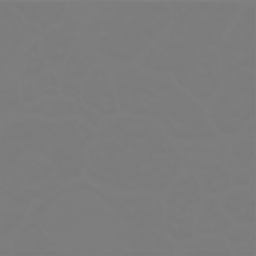

In [11]:
@load "unet_weights.jld2" weights
Flux.loadparams!(model, weights)

img, label = load_img_label(21, 256)
y_pred = model(img2array(unet_tiling(img)))

img_pred = array2img(y_pred)